# 基于昇思MindSpore+Orangepi AIpro的CycleGAN图像风格迁移

功能：使用基于昇思MindSpore框架开发的CycleGAN模型对输入图片进行风格迁移(apple2orange)。  
样例输入：原始图片jpg文件。  
样例输出：风格迁移后的图象。  

# 前期准备

* 基础镜像的样例目录中已包含转换后的om模型以及测试图片，如果直接运行，可跳过此步骤。如果需要重新转换模型，可以参考下面的步骤。
* **建议在Linux服务器或者虚拟机转换该模型。**
* 为了能进一步优化模型推理性能，我们需要将其转换为om模型进行使用；**转换指导详见全流程实验指导。**
  


# 模型推理实现

* 注意：本案例在离线推理的过程中可能会出现内存不足的问题，可以根据情况查看FAQ文档中的解决方案。

### 1. 导入三方库

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import mindspore.dataset as ds
from mindspore import Tensor
import mindspore.dataset.vision as vision

import acl
import acllite_utils as utils
import constants as const
from acllite_model import AclLiteModel
from acllite_resource import resource_list

### 2. 定义acllite资源初始化与去初始化类

In [2]:
class AclLiteResource:
    """
    AclLiteResource
    """
    def __init__(self, device_id=0):
        self.device_id = device_id
        self.context = None
        self.stream = None
        self.run_mode = None
        
    def init(self):
        """
        init resource
        """
        print("init resource stage:")
        ret = acl.init()

        ret = acl.rt.set_device(self.device_id)
        utils.check_ret("acl.rt.set_device", ret)

        self.context, ret = acl.rt.create_context(self.device_id)
        utils.check_ret("acl.rt.create_context", ret)

        self.stream, ret = acl.rt.create_stream()
        utils.check_ret("acl.rt.create_stream", ret)

        self.run_mode, ret = acl.rt.get_run_mode()
        utils.check_ret("acl.rt.get_run_mode", ret)

        print("Init resource success")

    def __del__(self):
        print("acl resource release all resource")
        resource_list.destroy()
        if self.stream:
            print("acl resource release stream")
            acl.rt.destroy_stream(self.stream)

        if self.context:
            print("acl resource release context")
            acl.rt.destroy_context(self.context)

        print("Reset acl device ", self.device_id)
        acl.rt.reset_device(self.device_id)
        print("Release acl resource success")

### 3. 定义风格迁移类，包含前处理、推理、后处理等操作

In [3]:
class CycleGan(object):
    """
    class for Cartoonization
    """
    def __init__(self, model_path):
        self._model_path = model_path

    def init(self):
        """
        Initialize
        """

        # Load model
        self._model = AclLiteModel(self._model_path)

        return const.SUCCESS
 
    @utils.display_time
    def pre_process(self, dir_path):
        """
        image preprocess
        """
        def read_img():
            for dir in os.listdir(dir_path):
                path = os.path.join(dir_path, dir)
                img = Image.open(path).convert('RGB')
                yield img, dir

        dataset = ds.GeneratorDataset(read_img, column_names=["image", "image_name"])
        trans = [vision.Resize((256, 256)), vision.Normalize(mean=[0.5 * 255] * 3, std=[0.5 * 255] * 3), vision.HWC2CHW()]
        dataset = dataset.map(operations=trans, input_columns=["image"])
        dataset = dataset.batch(1)

        return dataset

    @utils.display_time
    def inference(self, dataset):
        """
        model inference
        """       
        for i, data in enumerate(dataset.create_dict_iterator()):       
            img = data["image"]
            fake = self._model.execute([img.asnumpy(), ])
        return img, fake
            
    @utils.display_time
    def post_process(self, img, fake):
        """
        post process
        """
        fig = plt.figure(figsize=(8, 4), dpi=100)   
        fake = Tensor.from_numpy(fake[0])
        fake = (fake[0] * 0.5 * 255 + 0.5 * 255).astype(np.uint8).transpose((1, 2, 0))
        img = (img[0] * 0.5 * 255 + 0.5 * 255).astype(np.uint8).transpose((1, 2, 0))

        fig.add_subplot(2, 1, 1)
        plt.axis("off")
        plt.imshow(img.asnumpy())

        fig.add_subplot(2, 1, 2)
        plt.axis("off")
        plt.imshow(fake.asnumpy())
        plt.show()

### 4. 构造主函数，串联整个代码逻辑

In [ ]:
from download import download

# 获取模型om文件
model_url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-mindspore/05-CycleGAN/CycleGan.zip"
download(model_url, "./", kind="zip", replace=True)

In [4]:
def main():
    MODEL_PATH ="CycleGan.om"

    acl_resource = AclLiteResource()  # 初始化acl资源
    acl_resource.init()
    
    # instantiation CycleGan object
    cyclegan = CycleGan(MODEL_PATH)  # 构造模型对象
    
    # init
    ret = cyclegan.init()  # 初始化模型类变量
    utils.check_ret("CycleGan.init ", ret)  
    
    dir_path = "./data"

    # preprocess
    dataset = cyclegan.pre_process(dir_path)  # 前处理
    # inference
    img, fake = cyclegan.inference(dataset)  # 推理
    # postprocess
    cyclegan.post_process(img, fake)   # 后处理

### 5. 运行
运行完成后，会显示原图片和推理后的图片，如下所示。

init resource stage:
Init resource success
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 786432
Create model output dataset success
Init model resource success
in pre_process, use time:0.005691051483154297
in inference, use time:0.10941195487976074


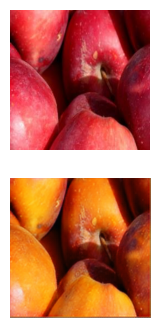

in post_process, use time:301.1996519565582
acl resource release all resource
AclLiteModel release source success
acl resource release stream
acl resource release context
Reset acl device  0
Release acl resource success


In [5]:
main()

其中，除了acl相关资源初始化和释放的信息外，“in pre_process, use time”表示前处理耗时，“in inference, use time”表示推理耗时，“in post_process, use time”表示后处理耗时，单位都为秒。

# 样例总结

我们来回顾一下以上代码，可以包括以下几个步骤：
1. 初始化acl资源：在调用acl相关资源时，必须先初始化AscendCL，否则可能会导致后续系统内部资源初始化出错。  
2. 对图片进行前处理：使得模型正常推理。  
3. 推理：利用AclLiteModel.execute接口对图片进行推理。  
4. 对推理结果进行后处理：使得图片正常画出。  
5. 可视化图片：利用plt将结果画出。